# CIFAR10 Classification w/ Linear Layers
- Data Home: https://www.cs.toronto.edu/~kriz/cifar.html

## Study Objective
- A little bit up to somewhere in https://www.kaggle.com/c/cifar-10/leaderboard

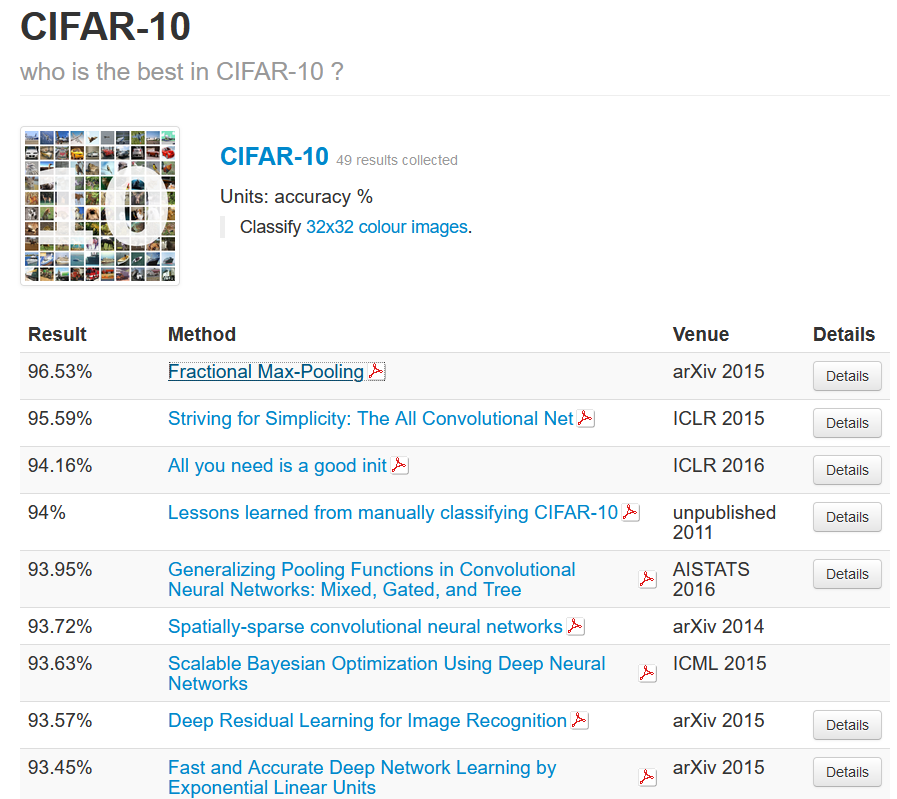

## Getting the Data

![CIFAR10](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import time

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
tvset = ['train', 'val']
dataset = {'train': torchvision.datasets.CIFAR10('../data', train=True, download=True),
              'val' : torchvision.datasets.CIFAR10('../data', train=False, download=True) }

class_names = ['airplane', 'automobile' , 'bird' , 'cat' ,  'deer' ,  'dog' ,  'frog' ,  'horse' ,  'ship' , 'truck']

Files already downloaded and verified
Files already downloaded and verified


### torchvision datasets are of type PIL

In [3]:
im, label = dataset['train'][0]
im, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x210178325C8>, 6, 'frog')

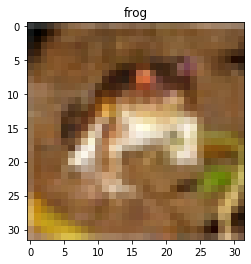

In [4]:
plt.imshow(im, cmap='gray')
plt.title(class_names[label]);

### PIL to tensor
- include transforms when dataset is created.

In [5]:
xforms = transforms.Compose([transforms.ToTensor()])
dataset = {'train': torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=xforms),
           'val' : torchvision.datasets.CIFAR10('../data', train=False, download=True, transform=xforms) }

print([(k, len(dataset[k])) for k in dataset.keys()])

Files already downloaded and verified
Files already downloaded and verified
[('train', 50000), ('val', 10000)]


### now the return data is torch.tensor, float32
- The order is: CHW : Channel, Height, Weight
- pixel values are scaled to [0,1]

In [6]:
im, label = dataset['train'][0]

n_pixels = im.shape[0]*im.shape[1]*im.shape[2]

im.dtype, im.shape, torch.max(im), torch.min(im), label, type(label), n_pixels

(torch.float32, torch.Size([3, 32, 32]), tensor(1.), tensor(0.), 6, int, 3072)

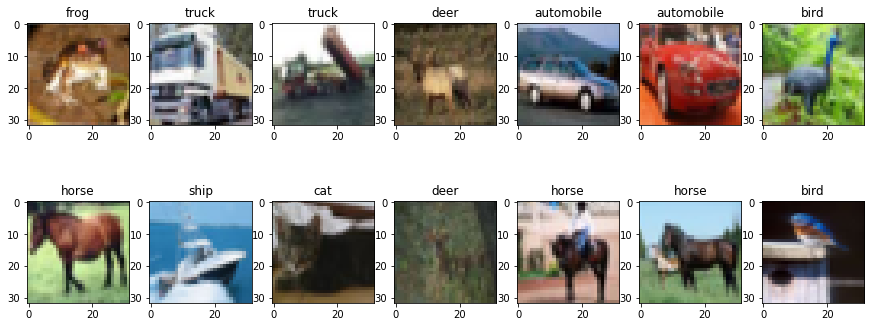

In [7]:
fig, axes = plt.subplots(2,7, figsize=(15,6))
for i, ax in enumerate(axes.reshape(-1)):
    im, label = dataset['train'][i]
    ax.imshow(im.permute(1,2,0))
    ax.set_title(class_names[label])

## Dataloaders

In [8]:
dataset.keys()

dict_keys(['train', 'val'])

In [9]:
#
def get_data_loader(batch_size):
    data_loader = { tv: torch.utils.data.DataLoader(dataset[tv], batch_size=batch_size, 
                                                    shuffle=tv=='train')
                   for tv in dataset.keys()}
    return data_loader

batch_size = 8
data_loader = get_data_loader(batch_size)

## Network Model & Loss Function

In [26]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, n_pixels) # (Batch, Features)
#

# A very simple model
def make_model(option=1, n_targets=10):
    in_ft = n_pixels
    
    if option == 1:
        model = nn.Sequential(Reshape(),
                              nn.Linear(in_features=in_ft, out_features=n_targets) )
    elif option == 2:
        model = nn.Sequential(Reshape(),
                              nn.Linear(in_features=in_ft, out_features=in_ft//2),
                              nn.Tanh(),
                              nn.Linear(in_ft//2, n_targets))
    elif option == 3:
        model = nn.Sequential(Reshape(),
                              nn.Linear(in_features=in_ft, out_features=in_ft//2),
                              nn.Tanh(),
                              nn.Linear(in_features=in_ft//2, out_features=in_ft//4),
                              nn.Tanh(),
                              nn.Linear(in_ft//4, n_targets))
    return model
#
loss_fn = nn.CrossEntropyLoss()

### About CrossEntropyLoss() & Soft-Max 
- Suppose we give a data $x$ of class $k$. The model outputs 10 dimensional score vector  $s$.
- Softmax is the next procedure to be applied to the score vector to produce predicted class probabilities $q$:
$$
    \begin{align}
        q_i & = {e^{s_i}}\big/{\sum_j e^{s_j}} \\
            & = \mbox{softmax(s, label=i)}
    \end{align}
$$

- Loss function is chosen to be cross entropy, as all the other classification problems:
$$
    H(p, q) = -\sum_i p_i \log q_i
$$

- Here we have model probability $p=OneHot(k)$ which has 0s at all the locations but 1 at the $k$th location.   It does not have to be OneHot vector as a probability density model. If an input may be categorized to two objects at the same time, $p=[0,... 1/2, ..., 1/2, ... 0]$.

$$ p=OneHot(k) = [0, ... 1 ... 0] 
$$
    
- Therefore, the cross-entropy for this particular case is

$$
    \begin{align}
        H(p, q)  & =  - p_k \log q_k \\
                 & =  - \log q_k     \\
                 & =  - \log\big( {e^{s_k}}/{\sum_j e^{s_j}} \big) \\
                 & = -\bigg(s_k - \log\big(\sum_j e^{s_j}\big) \bigg)
    \end{align}
$$

- Numerical computation of this formula is much more stable than computing $\log(\exp(s_k))$ step by step.
- Given a score vector, pytorch `nn.CrossEntropyLoss()` computes this loss.
- That is, `nn.CrossEntropyLoss()` = `NLLLoss(LogSoftMax())`

* Why Cross Entropy?
    - $H(p, q)$ has a minimum value when $q$ is equal to $p$.

---
### Cross Entropy & Maximum Likelihood Estimate

- The probability mass function $q_i=P(C=i|x)$, i=0...9, of being class $i$ given an input $x$ is computed through a neural network model.
- Given this probatility mass $q=[q_i]$, what is the data likelihood?
    - In the case of Gaussian distribution modeling, the output of neural network model is the mean $\mu(x)$ and std $\sigma(x)$ given $x$. The likelihood is given by
    $$
        \begin{align}
        L & = Prob( y-delta < y < y+delta | x) \\
          & = \delta \cdot \cal{N}(x| \mu(x), \sigma(x)) \\
          & = \exp\bigg\{ -0.5 (y - \mu(x))^2 / \sigma(x)^2 \bigg\} \big/ \sqrt{2\pi}\sigma(x)
        \end{align}
    $$
    This is used for regression problems. Linear regression must be the easiest case.
    - In case of Bernoulli distribution, given a probability $p$ given by a NN model $p(x)$, the likelihood is 
    $$
        L = Prob(label = 1 | x) = p = p(x, w)
    $$
    - In cas of Multinoulli distribution, we have $C=10$ multiple candidates and $C$ discrete probabilities $p_i$, $\sum_i p_i = 1$
    
    - Since we are trying to make a model that predicts the probability, given a data $(x, k)$, $k$ being a GT label, we have a predicted probability vector $q_i = \mbox{NN}(x; w) \in \mathbb{R}^{10}$. It is an estimate of true $p_i$, The likelihood is 
    $$
        \begin{align}
            L   & = Prob(label = k | x) = q_k \\
                & = \mbox{ the $k$-th output from SoftMax() }
        \end{align}
    $$
    and we want to maximize $L$, the class probability, by modifying $w$, the parameters of NN.
    - For numerical stability mostly, we may instead maximize its logarithmic version
    $$
        l = l(w) = \log q_k(x, w)
    $$
    - The numerical package in PyTorch does only minimization. So we minimize the negative of the log-likelihood:
    $$
        \begin{align}
            NLL(w) & = -l(w) \\
                    & = -\log q_k(x, w) \\
                    & = - \log\big(\mbox{SoftMax}(s_k(x,w))\big)
        \end{align}
    $$
    

---
### Cross Entropy & Kullback-Leibler divergence
- KL Divergence
$$
    D_\mathrm{K}(p||q) = H(p,q) - H(p,p)
$$
- Cross Entropy
$$
    H(p,q) = - \sum_i p_i \log q_i
$$
- Information Entropy (Average Information)
$$
    \begin{align}
        H(p,p) = H(p) & = - \sum_i p_i \log p_i \\
        & = \sum_i p_i \log \frac{1}{p_i}
    \end{align}
$$
- Information
$$
    I(p_i) = \log\frac{1}{p_i} = I(x_i)
$$
where $x_i$ is a particular outcome of a random variable $X$.
    - Expection of $I(x_i)$ is defined to be $H(p)$ or denoted to be $H(X)$
    $$
        \mathbb{E}(I(x_i)) = H(p) = H(X)
    $$
#### References
- https://en.wikipedia.org/wiki/Entropy_(information_theory)
- https://en.wikipedia.org/wiki/Cross_entropy
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence


## Training Loop

In [11]:
%%file training_loop.py

import torch
import matplotlib.pyplot as plt

def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, 
                  hist=None, 
                  lr_scheduler=None,
                  device=torch.device('cpu')):
    best_acc = 0

    if hist is not None:
        best_acc = max(hist['vacc'])
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = [] # records lr after each epoch

    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        model.train() # in train mode
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val, device)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated at epoch {epoch}: {best_acc}.', end='\r')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss); hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc);   hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader, device=torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#


Overwriting training_loop.py


In [12]:
# jupyter kernel must be initialized if the file has changed
from training_loop import training_loop, count_params, plot_history

## Training Setup

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model().to(device)
print(model)
print('num params: ', count_params(model))

learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

cuda
Sequential(
  (0): Reshape()
  (1): Linear(in_features=3072, out_features=10, bias=True)
)
num params:  30730


## First Trial

Epoch 1, tloss 76.32 t_acc: 0.24  vloss 63.28  v_acc: 0.26
Epoch 2, tloss 75.78 t_acc: 0.27  vloss 105.45  v_acc: 0.24
Epoch 3, tloss 71.30 t_acc: 0.27  vloss 57.06  v_acc: 0.27
Epoch 4, tloss 63.07 t_acc: 0.28  vloss 68.31  v_acc: 0.31
Epoch 5, tloss 53.40 t_acc: 0.29  vloss 48.26  v_acc: 0.29
Epoch 10, tloss 8.05 t_acc: 0.40  vloss 10.03  v_acc: 0.32
finished training_loop().
Wall time: 3min 10s


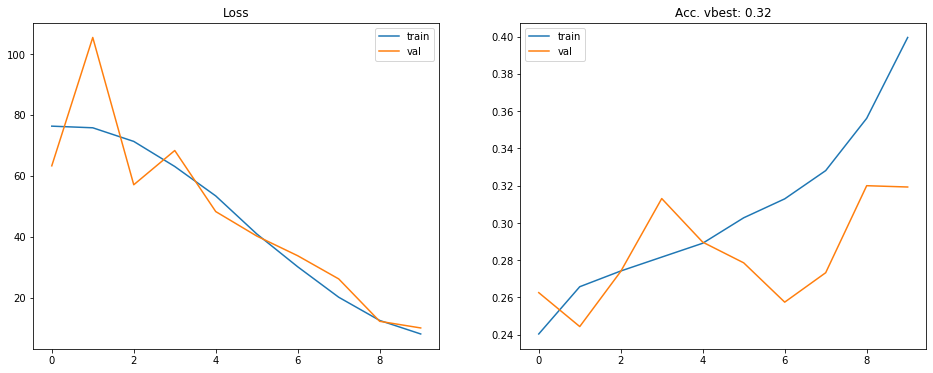

In [14]:
%%time

history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
plot_history(history)

## Try to Change Batch Size
- computation speed

In [19]:
data_loader = get_data_loader(batch_size=1024)

model = make_model().to(device)
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Reshape()
  (1): Linear(in_features=3072, out_features=10, bias=True)
)
30730


Epoch 1, tloss 176.43 t_acc: 0.11  vloss 230.91  v_acc: 0.14
Epoch 2, tloss 157.13 t_acc: 0.12  vloss 94.29  v_acc: 0.16
Epoch 3, tloss 94.73 t_acc: 0.18  vloss 75.57  v_acc: 0.20
Epoch 4, tloss 50.82 t_acc: 0.20  vloss 32.30  v_acc: 0.22
Epoch 5, tloss 30.10 t_acc: 0.22  vloss 21.67  v_acc: 0.22
Epoch 10, tloss 19.57 t_acc: 0.22  vloss 24.66  v_acc: 0.26
finished training_loop().ated at epoch 10: 0.2631.
Wall time: 56.3 s


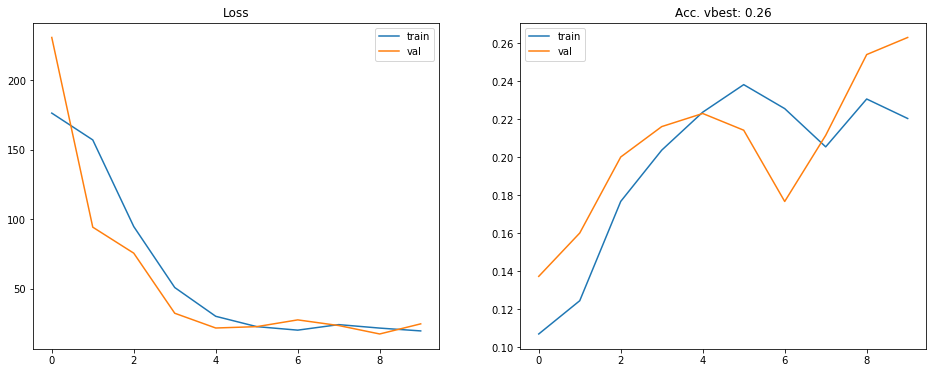

In [20]:
%%time
history = training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
plot_history(history)

## Try More Complex Model with Additional Layers

In [21]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=2).to(device)
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Reshape()
  (1): Linear(in_features=3072, out_features=1536, bias=True)
  (2): Tanh()
  (3): Linear(in_features=1536, out_features=10, bias=True)
)
4735498


Epoch 1, tloss 88.24 t_acc: 0.11  vloss 89.58  v_acc: 0.10
Epoch 2, tloss 81.73 t_acc: 0.11  vloss 112.48  v_acc: 0.10
Epoch 3, tloss 70.49 t_acc: 0.11  vloss 45.70  v_acc: 0.16
Epoch 4, tloss 42.84 t_acc: 0.13  vloss 26.32  v_acc: 0.16
Epoch 5, tloss 25.67 t_acc: 0.15  vloss 35.75  v_acc: 0.11
Epoch 30, tloss 2.80 t_acc: 0.15  vloss 2.74  v_acc: 0.15
finished training_loop().
Wall time: 2min 57s


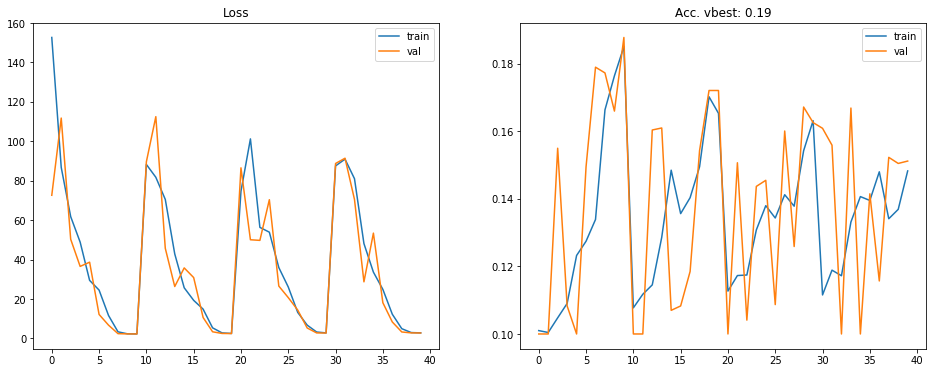

In [23]:
%%time
history = training_loop(30, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
plot_history(history)

## Try SGD and learning_rate

In [24]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=2).to(device)
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Reshape()
  (1): Linear(in_features=3072, out_features=1536, bias=True)
  (2): Tanh()
  (3): Linear(in_features=1536, out_features=10, bias=True)
)
4735498


Epoch 1, tloss 2.23 t_acc: 0.21  vloss 2.17  v_acc: 0.27
Epoch 2, tloss 2.13 t_acc: 0.27  vloss 2.09  v_acc: 0.29
Epoch 3, tloss 2.07 t_acc: 0.29  vloss 2.05  v_acc: 0.30
Epoch 4, tloss 2.03 t_acc: 0.31  vloss 2.01  v_acc: 0.32
Epoch 5, tloss 2.00 t_acc: 0.32  vloss 1.99  v_acc: 0.32
Epoch 30, tloss 1.84 t_acc: 0.37  vloss 1.84  v_acc: 0.37
finished training_loop().
Wall time: 2min 56s


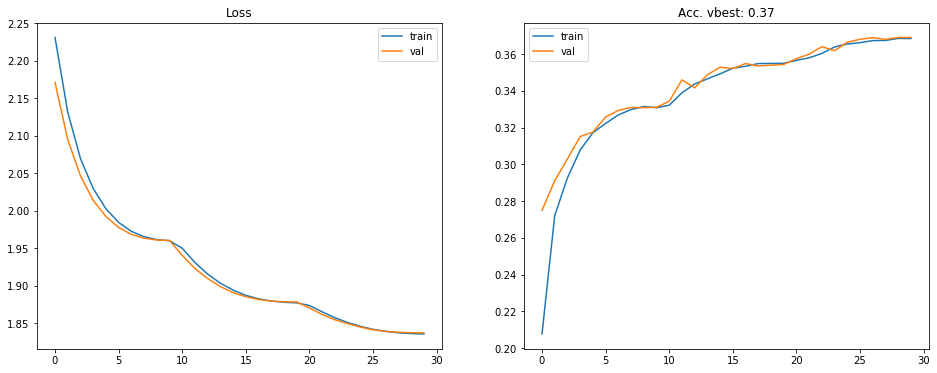

In [25]:
%%time
history = training_loop(30, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
plot_history(history)

## More Layers

In [27]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=3).to(device)
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Reshape()
  (1): Linear(in_features=3072, out_features=1536, bias=True)
  (2): Tanh()
  (3): Linear(in_features=1536, out_features=768, bias=True)
  (4): Tanh()
  (5): Linear(in_features=768, out_features=10, bias=True)
)
5908234


Epoch 1, tloss 2.27 t_acc: 0.15  vloss 2.24  v_acc: 0.20
Epoch 2, tloss 2.21 t_acc: 0.23  vloss 2.19  v_acc: 0.24
Epoch 3, tloss 2.16 t_acc: 0.26  vloss 2.14  v_acc: 0.27
Epoch 4, tloss 2.12 t_acc: 0.27  vloss 2.10  v_acc: 0.29
Epoch 5, tloss 2.09 t_acc: 0.29  vloss 2.08  v_acc: 0.29
Epoch 30, tloss 1.88 t_acc: 0.35  vloss 1.88  v_acc: 0.35
finished training_loop().
Wall time: 2min 57s


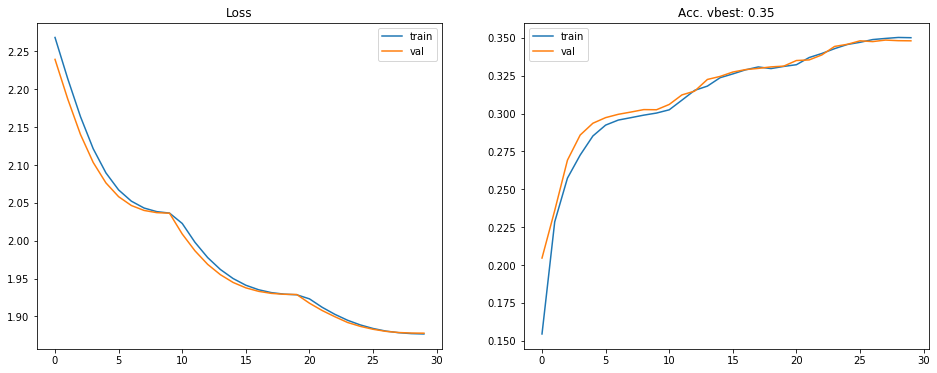

In [28]:
%%time
history = training_loop(30, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
plot_history(history)

### Adam?

- Did not work with me.

---
## Some Thoughts
Not easy to include more layers due to 
- memory limit
- sigmoid/tanh, properties of activation functions and vanishing gradient
    - batch normalization
    - ReLU, ELU, PRELU
    - activation functions do not have learnable parameters
- overfitting, many many parameters
    - batch normalization
    - dropout
    - weight decay

## Batch Normalization
- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, Sergey Ioffe, Christian Szegedy, 2015
- https://en.wikipedia.org/wiki/Batch_normalization
- [PR-021: Batch Normalization](https://www.youtube.com/watch?v=TDx8iZHwFtM) video tutorial

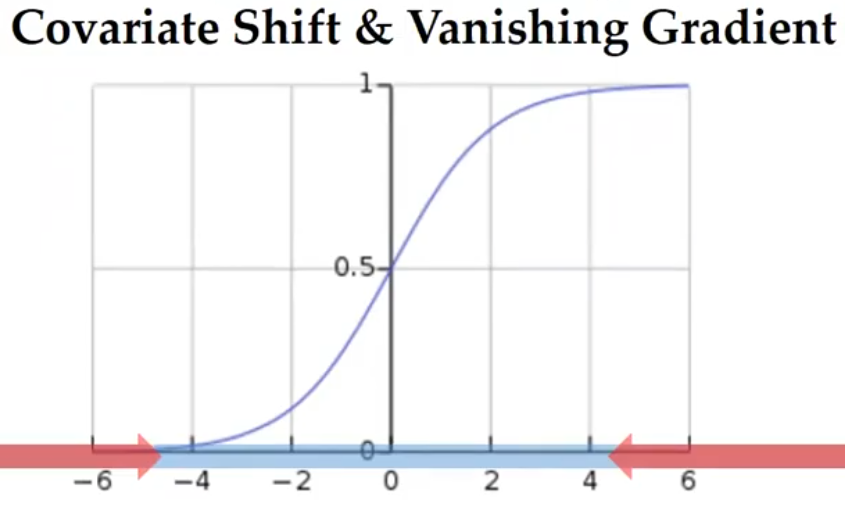

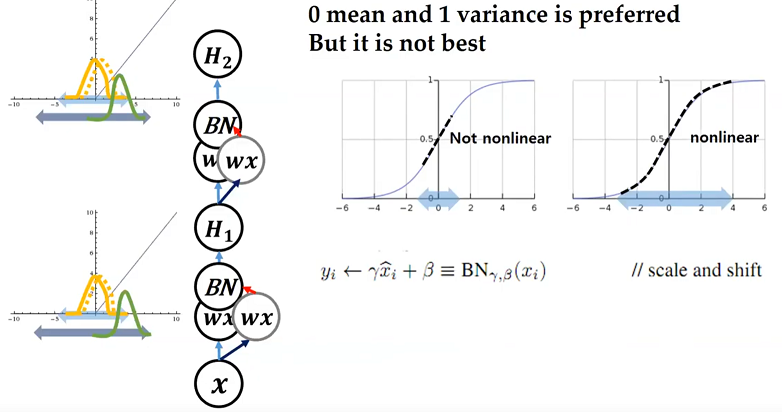

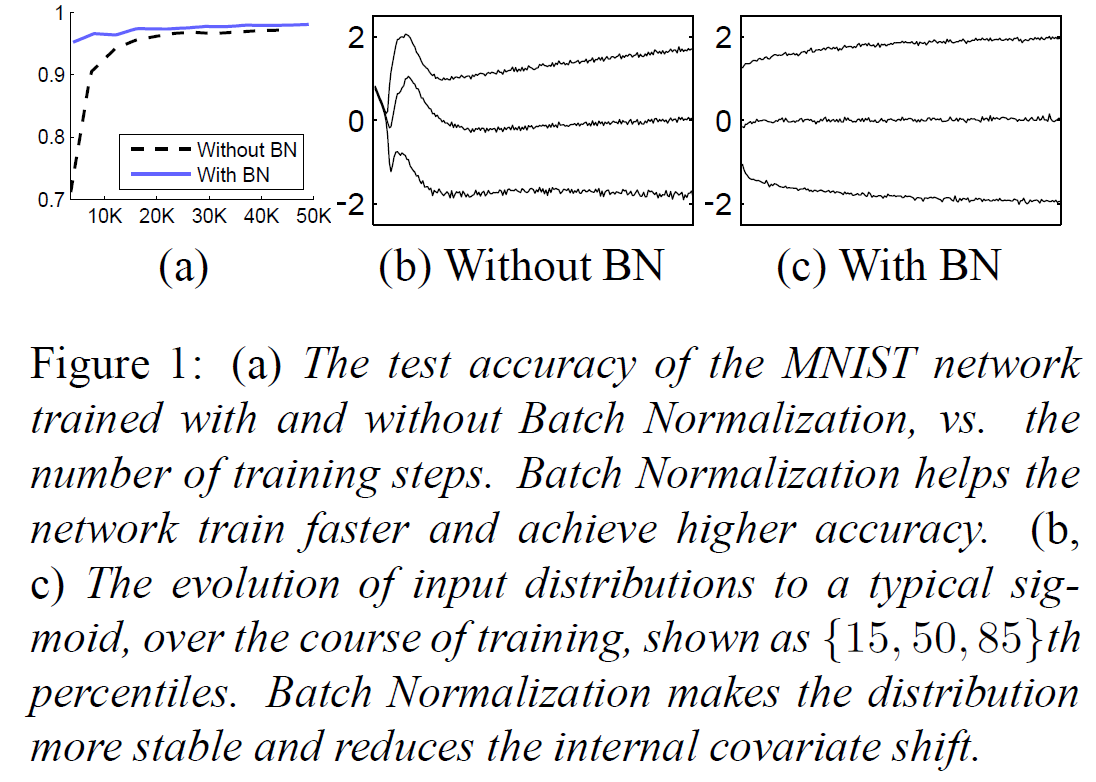

---

End.